# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

SELF_TEST = True

In [2]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-09-13 18:10:44,128 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [3]:
nb_dir = os.path.split(os.getcwd())[0]

if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.6
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [4]:
from pathlib import Path
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [5]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection
from pymongo import ASCENDING

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


### Import docs having insideInformation

In [8]:

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]

query = {
  '$and': [
#     {"parse.documentType": "CONTRACT"},      
#     {"state": 15},
    {'$or': [
        {"user.attributes_tree.contract.subject.insideInformation": {"$ne": None}},
        {"user.attributes_tree.contract.insideInformation": {"$ne": None}}
    ]}
  ]
}

res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}

                               ).limit(1000)

res_inside = list([i for i in res])

_s = f"#### Всего документов с инсайдом  {len(res_inside)}"
display(Markdown(_s))

if SELF_TEST:
    res_inside[:5]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего документов с инсайдом  81

[{'_id': ObjectId('60af4d8f0b62ae6e622cc161'),
  'user': {'updateDate': datetime.datetime(2021, 7, 30, 12, 14, 8, 564000)}},
 {'_id': ObjectId('60defc4e95588e4cfb432c28'),
  'user': {'updateDate': datetime.datetime(2021, 7, 23, 10, 22, 50, 433000)}},
 {'_id': ObjectId('60df005595588e4cfb432c2a'),
  'user': {'updateDate': datetime.datetime(2021, 7, 16, 10, 46, 21, 627000)}},
 {'_id': ObjectId('60ebf4a7cddbb3c487368c2d'),
  'user': {'updateDate': datetime.datetime(2021, 7, 15, 14, 37, 50, 295000)}},
 {'_id': ObjectId('60ec1da0cddbb3c487368c39'),
  'user': {'updateDate': datetime.datetime(2021, 7, 15, 14, 47, 33, 598000)}}]

### Вынимаем размеченные людьми инсайды из базы

In [9]:
lines=[]
for k, oid in enumerate([i["_id"] for i in res_inside]  ):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    tree=jd.user['attributes_tree']
    c = tree.get('contract', {})
    ins = c.get('insideInformation') or  c.get('subject', {}).get('insideInformation', {}) 
    print('-'*100)
    print(k, ins)
#     doc=jd.asLegalDoc()
#     quote = doc[ins['span']]
    doc = jd.asLegalDoc()
    s = ins['span']
    quote = doc[s[0]: s[1]].get_text()
    print(quote)
    lines.append( [oid, s[0], s[1], quote, ins['value']]  )
    
insides = DataFrame(lines, columns=['uid', 'from','to', 'text', 'value'])
insides

----------------------------------------------------------------------------------------------------
0 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [130, 199], 'span_map': 'words', 'value': 'Deals', 'changed': True, 'parent': 'subject'}
Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект
----------------------------------------------------------------------------------------------------
1 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [330, 529], 'span_map': 'words', 'value': 'Deals', 'changed': True, 'parent': ''}
3.1. Покупатель производит оплату общей стоим

----------------------------------------------------------------------------------------------------
14 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [1515, 1532], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
4.6. Представлять бухгалтерскую и прочую отчетность, подготовка которой осуществляется Заемщиком в соответствии с Законодательством,
----------------------------------------------------------------------------------------------------
15 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [112, 117], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
комплексное правовое сопровождение деятельности Заказчика


----------------------------------------------------------------------------------------------------
16 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [2894, 2912], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
Банк ВТБ открывает по просьбе Клиента Аккредитивы на основании Заявлений на Аккредитив при условии согласия с условиями Аккредитивов


----------------------------------------------------------------------------------------------------
17 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [398, 406], 'span_map': 'words', 'value': 'IssuedSecurities', 'changed': True, 'parent': 'subject'}
услуги, связанные с выпуском и обращением Облигаций
----------------------------------------------------------------------------------------------------
18 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [166, 173], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
аудита бухгалтерской (финансовой) отчетности Заказчика


----------------------------------------------------------------------------------------------------
19 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [94, 114], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
услуги по обзорной проверке (далее – «Услуги») следующей финансовой информации промежуточных сокращенных консолидированных финансовых отчетностей Клиента
----------------------------------------------------------------------------------------------------
20 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [514, 541], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
2.2.1. Предоставлять Банку всю необходимую, полную и достоверную информацию, которая может быть разумно потребована Банком для целей исполнения им своих обязательств по Соглашению.
----------------------------------------------------------------------------------------------------
21

----------------------------------------------------------------------------------------------------
22 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [426, 451], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывной оферты ("Оферта") предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи")
----------------------------------------------------------------------------------------------------
23 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [99, 168], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
Кредитор обязуется открыть Заемщику невозобновляемую кредитную линию для финансирования общекорпоративных целей Заемщика, в том числе финансирования текущих расходов Заемщика (включая, но не ограничиваясь: финансирование затрат на закупку 

----------------------------------------------------------------------------------------------------
25 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1481, 1541], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывных оферт предоставляет Акцептанту право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об уступке Акцептантом всех Прав Требования к Обществу (в том числе будущих Прав Требования, которые могут возникнуть после Даты Соглашения) ("Оферта 2", а совместно с Офертой 1 - "Оферты")


----------------------------------------------------------------------------------------------------
26 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1213, 1229], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи")


----------------------------------------------------------------------------------------------------
27 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [1454, 1508], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Клиент соглашается своевременно предоставлять или обеспечивать предоставление Консультанту такой финансовой и иной информации (включая все документы, договоры и учетную информацию), касающейся Сделки, которая имеет или может иметь отношение для понимания условий (финансовых или иных), бизнеса, результатов, операционных данных и перспектив Компании – Оператора Проекта


----------------------------------------------------------------------------------------------------
28 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [455, 457], 'span_map': 'words', 'value': 'IssuedSecurities', 'changed': True, 'parent': 'subject'}
размещения Облигаций
----------------------------------------------------------------------------------------------------
29 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [2650, 2683], 'span_map': 'words', 'value': 'SD', 'changed': True, 'parent': ''}
3.2.3. Предоставлять Регистратору информацию о решениях органов управления Эмитента, касающихся условий и порядка деятельности Эмитента и затрагивающих вопросы, носящие существенный характер для осуществления Регистратором своих обязанностей по настоящему Договору.


----------------------------------------------------------------------------------------------------
30 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [3021, 3042], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
копии годового бухгалтерского баланса и отчета о финансовых результатах Заемщика, включая копии приложений к указанным документам с отметкой налоговой инспекции
----------------------------------------------------------------------------------------------------
31 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [109, 115], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
комплекс услуг по ведению бухгалтерского учета
----------------------------------------------------------------------------------------------------
32 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [203, 211], 'span_map': 'words',

----------------------------------------------------------------------------------------------------
37 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [871, 880], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
разработку и реализацию стратегии продажи Обществ совместно с Клиентом
----------------------------------------------------------------------------------------------------
38 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [145, 173], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
услуги («Услуги») по сложным методологическим вопросам учета и представления информации в отчетности в соответствии с Международными стандартами финансовой отчетности («МСФО»)
----------------------------------------------------------------------------------------------------
39 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'sp

----------------------------------------------------------------------------------------------------
42 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [500, 523], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
защиты Конфиденциальной информации, предоставленной Раскрывающей стороной Принимающей стороне с целью получения информации об оборудовании планируемому к ОПИ/ПЭ (Опытно-промышленные испытания/подконтрольная эксплуатация)
----------------------------------------------------------------------------------------------------
43 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [6557, 6625], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Предоставлять Кредитору ежеквартально не позднее 10 (Десяти) рабочих дней с даты окончания календарного месяца, следующего за отчетным периодом (кварталом, полугодием, 9 (Девятью) месяцами), а по окончании отчетного год

----------------------------------------------------------------------------------------------------
44 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1688, 1753], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об уступке Акцептантом всех Прав Требования к Обществу (в том числе будущих Прав Требования, которые могут возникнуть после Даты Соглашения) ("Оферта 2", а совместно с Офертой 1 - "Оферты"), на условиях, предусмотренных Соглашением ("Опцион")
----------------------------------------------------------------------------------------------------
45 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [108, 114], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
услуги по определению стоимости объекта оценки
--------------------------------

----------------------------------------------------------------------------------------------------
47 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1204, 1241], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывной оферты ("Оферта") предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи"), на условиях, предусмотренных настоящим Соглашением ("Опцион")
----------------------------------------------------------------------------------------------------
48 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [163, 234], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывных оферт предоставляет Акцептанту право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об

----------------------------------------------------------------------------------------------------
50 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [2853, 2877], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
предоставляются копии платежных поручений о перечислении указанных сумм (с отметкой об исполнении) и (или) налоговых деклараций (бухгалтерской отчетности)
----------------------------------------------------------------------------------------------------
51 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [121, 128], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
оказать Заказчику услуги по поддержке информационных систем
----------------------------------------------------------------------------------------------------
52 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [6343, 6406], 'span_map': 'words'

----------------------------------------------------------------------------------------------------
54 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [11720, 11762], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
11.2.8. Предоставлять в Банк ВТБ или обеспечить на ежеквартальной основе размещение на официальном сайте Клиента в сети «Интернет» (http://www. gazprom-neft. ru) копии актуальной бухгалтерской отчетности Клиента по РСБУ, заверенной уполномоченными лицами Клиента
----------------------------------------------------------------------------------------------------
55 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [268, 282], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
Общество передает Интерфакс-ЦРКИ информацию, подлежащую раскрытию Обществом согласно требованиям действующего законодательства Российской Федерации
---------------------------

----------------------------------------------------------------------------------------------------
60 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [5133, 5138], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
на основании зарегистрированной отчетности компании
----------------------------------------------------------------------------------------------------
61 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [149, 169], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Анализ бухгалтерской (финансовой) отчетности обществ, входящих в Группу Газпром нефть, в рамках работы ревизионных комиссий.
----------------------------------------------------------------------------------------------------
62 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [147, 174], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}

,uid,from,to,text,value
0,60af4d8f0b62ae6e622cc161,130,199,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
1,60defc4e95588e4cfb432c28,330,529,3.1. Покупатель производит оплату общей стоимо...,Deals
2,60df005595588e4cfb432c2a,142,171,"2.1. Заказчик поручает, а Исполнитель принимае...",Accounting
3,60ebf4a7cddbb3c487368c2d,129,201,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
4,60ec1da0cddbb3c487368c39,129,200,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
...,...,...,...,...,...
76,612f5cb9ea1085618e03000f,152,190,Анализ бухгалтерской (финансовой) отчетности с...,Accounting
77,612f5cb9ea1085618e030011,147,192,Подготовка раскрытий для промежуточной сокраще...,Accounting
78,612f5cb9ea1085618e030013,144,253,• проверка отчетов об оценке рыночной стоимост...,Accounting
79,612f5cb9ea1085618e030017,143,167,Услуги по сопровождению и администрированию пр...,Accounting


### Очистка, сортировка, удаление дупликатов

In [10]:
insides = insides.drop_duplicates(subset=['text'], keep='last')
insides.sort_values(['value']).to_csv('insides.csv', index=True)

## Embedding patterns

In [11]:
from tf_support.embedder_elmo import ElmoEmbedder

embedder = ElmoEmbedder.get_instance()


DEBUG:gpn:creating ElmoEmbedderImpl instance


In [12]:
strings = [ r.text for i,r in  insides.iterrows() ]
strings[2:8]

['Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект»)',
 'Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект',
 'Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический ко

In [13]:
#just test
if False:
    t1 = insides.iloc[0].text
    t2 = insides.iloc[1].text
    print(t1, t1)
    embeddings = embedder.embedd_strings([t1, t2])
    print(embeddings)

In [14]:
embeddings = embedder.embedd_strings(strings)

INFO:gpn:< loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
INFO:gpn:TF hub cache dir is  /Users/artem/work/nemo/work/tf_cache
INFO:gpn:ELMO module loaded >
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2021-09-13 18:11:33.733401: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:gpn:graph finalized >>


(74, 1024)


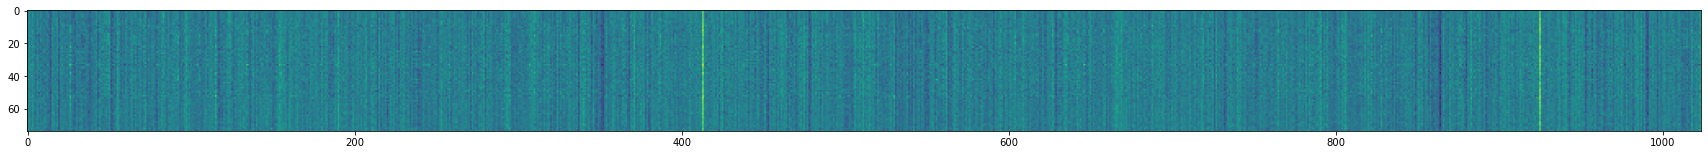

In [15]:
print(embeddings.shape)

plt.figure(figsize=(30,10))
plt.imshow(embeddings)


## pair-wise distances of Embeddings, removing duplicates

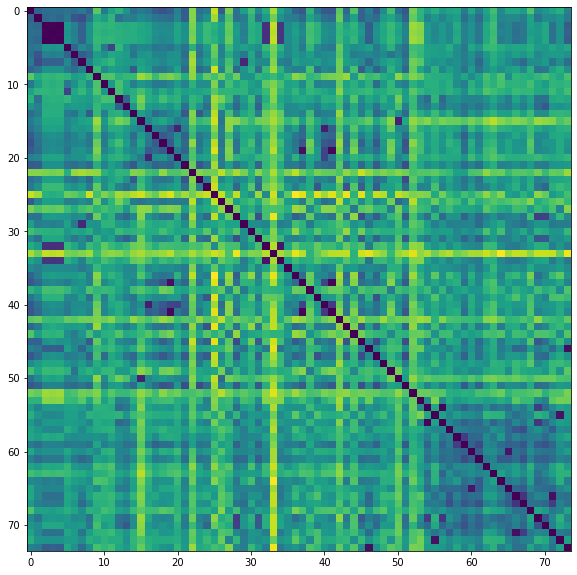

In [16]:
from sklearn.metrics import pairwise_distances
X = embeddings
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=1)
distance_matrix

plt.figure(figsize=(10,10))
plt.imshow(distance_matrix)

In [17]:
_excluded = set()
_kept = set()

display(Markdown('### Одинаковые:'))
for i in range(distance_matrix.shape[0]):
    for j in range(i+1, distance_matrix.shape[0]):
        d = distance_matrix[i,j]
        if d < 0.1:
            print(i,'vs', j, ', cosine distance =',d)
            _kept.add(i)
            _excluded.add(j)
            print(i, strings[i])
            print('==')
            print(j, strings[j])
            print('-'*100)
# _excluded

print(_kept-_excluded)
print(_excluded)

### Одинаковые:

2 vs 3 , cosine distance = 0.0077768564
2 Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект»)
==
3 Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект
----------------------------------------------------------------------------------------------------
2 vs 4 , cosine distance = 0.00085633993
2

In [18]:
import numpy as np
embeddings_filtered = np.delete(embeddings, list(_excluded), axis=0)
strings_filtered = np.delete(strings, list(_excluded), axis=0)
embeddings_filtered.shape

display(Markdown(f'### {embeddings_filtered.shape[0]} -- Количество паттернов после удаления одинаковых'))

### 60 -- Количество паттернов после удаления одинаковых

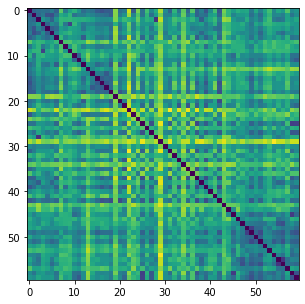

In [97]:

X = embeddings_filtered
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=1)
 
            
plt.figure(figsize=(5,5))
plt.imshow(distance_matrix)

## Clustering, t-SNE try

In [43]:
print(insides.value.unique())
n_clusters = len(insides.value.unique())
print('n_clusters', n_clusters)

['Deals' 'Accounting' 'IssuedSecurities' 'Plans' 'SharesOfParticipation'
 'SD' 'Courts']
n_clusters 7


In [99]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1300, metric="precomputed")
tsne_results = tsne.fit_transform(distance_matrix)

/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.001s...
[t-SNE] Computed neighbors for 60 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.314881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.020954
[t-SNE] KL divergence after 1300 iterations: 0.454509


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

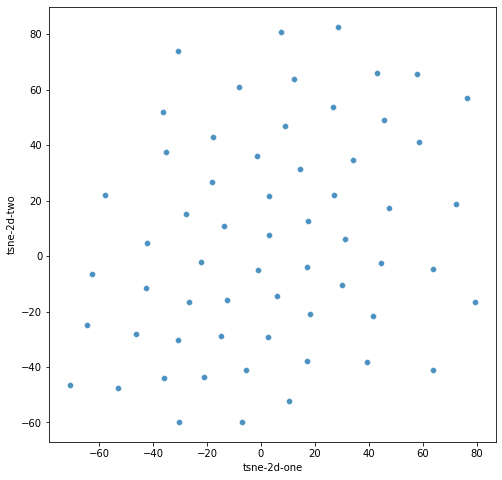

In [100]:
df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df_subset,
    alpha=0.8
)

## Clustering, PCA 

60 [[-2.384503    1.5201855 ]
 [ 2.0418448  -1.6451309 ]
 [-0.21726455  1.8328031 ]
 [ 3.6673756   0.43991476]
 [-0.47105712 -2.270313  ]
 [-3.7380464  -1.0898613 ]
 [ 4.9766355   5.634833  ]]


<AxesSubplot:xlabel='pca2d-one', ylabel='pca2d-two'>

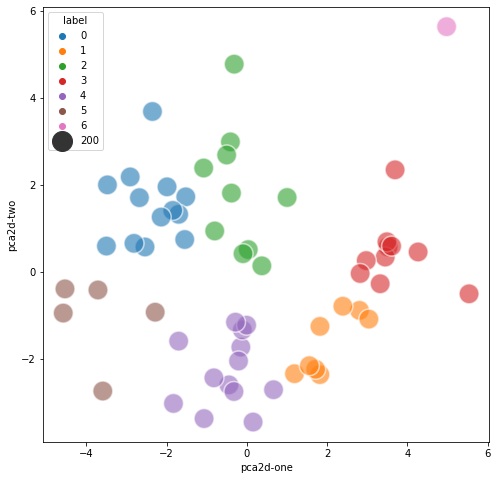

In [44]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_filtered)

df_subset={}
df_subset['pca2d-one'] = pca_result[:,0]
df_subset['pca2d-two'] = pca_result[:,1]


from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(np.array(pca_result))
print(len(kmeans.labels_), kmeans.cluster_centers_)
# print(len(kmeans.labels_), kmeans.labels_)

df_subset['label'] = kmeans.labels_

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca2d-one", y="pca2d-two",
    data=df_subset,
    hue="label", palette="tab10",
    alpha=0.6, size=[200]*len(kmeans.labels_), sizes=(400, 500)
)
# print(pca_result[:3])

In [45]:
insides.to_csv('insides.csv', index=True)

## Finding cluster centers (in embedding space)

In [46]:
from colab_support.renderer import HtmlRenderer
import matplotlib as matplotlib
from IPython.core.display import display, HTML

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()

if SELF_TEST:
    renderer_.render_color_text(["слово 1", "слово 2"], np.array( [1, 0]), _range=(0,1))

In [47]:
lens = [ len (s) for s in strings]
print(lens)

mean_len = int(np.mean(lens) * 1.75)
print(mean_len)

[1233, 171, 405, 403, 406, 95, 120, 310, 132, 57, 132, 51, 54, 153, 180, 81, 177, 482, 524, 344, 127, 369, 20, 265, 160, 71, 208, 86, 851, 218, 70, 175, 249, 18, 219, 220, 422, 334, 46, 118, 240, 397, 88, 154, 59, 413, 318, 262, 147, 46, 101, 451, 74, 51, 124, 112, 123, 103, 196, 732, 179, 322, 226, 118, 253, 172, 525, 406, 130, 275, 330, 518, 107, 290]
420


In [48]:
centroid = np.mean(embeddings_filtered, axis=0)
centroids = []
print(centroid)

for k in range(len(kmeans.cluster_centers_)):
    group=[]
    for i in range(len(embeddings_filtered)):
        if k == kmeans.labels_[i]:
#             print (k)
            group.append(embeddings_filtered[i])
    print(len(group))
    c = np.mean(group, axis=0)
    centroids.append(c)
    print( c )

[-0.01623254  0.25354055 -0.00401501 ...  0.12817813 -0.01284518
  0.4445965 ]
13
[-0.00371232  0.1987485  -0.02782255 ...  0.22566411 -0.06766213
  0.5577017 ]
8
[ 0.1468724   0.3092757  -0.14899282 ...  0.07274887 -0.03572573
  0.49951908]
10
[-0.21003203  0.2818889   0.10656399 ...  0.09178588 -0.00363106
  0.36433968]
10
[-0.0263846   0.3765912  -0.11096466 ...  0.02246249  0.15411137
  0.24845271]
13
[-0.01099953  0.2365173  -0.00998203 ...  0.12564787  0.03533988
  0.5209609 ]
5
[ 0.09338836  0.07301176  0.17355981 ...  0.3271734  -0.20562255
  0.634175  ]
1
[-0.06045262  0.12991256  0.61870956 ... -0.23670909 -0.5414062
 -0.64177674]


In [49]:
from analyser.hyperparams import models_path
models_path

'/Users/artem/work/nemo/analyser/analyser/vocab'

# Save patterns  (embeddings binary array)

In [50]:
np.save(Path(models_path) / "insides_patterns.npy",  centroids)

# Analysing sample doc

In [51]:
if SELF_TEST:    
    centroids = np.load(Path(models_path) / "insides_patterns.npy")
    print(centroids.shape)

(7, 1024)


In [70]:
if SELF_TEST:
    

    sample_id     = res_inside[0]["_id"]
    sample_db_doc = get_doc_by_id(sample_id)
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()


    from analyser.legal_docs import tokenize_doc_into_sentences_map
    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), mean_len)

    print(sample_doc)

    doc_embeddings = embedder.embedd_strings(sample_doc.sentence_map.tokens)

/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


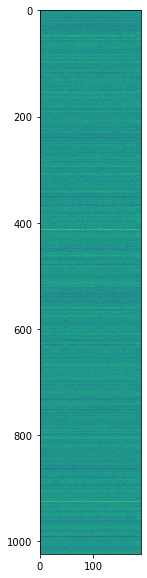

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(doc_embeddings.T)

190


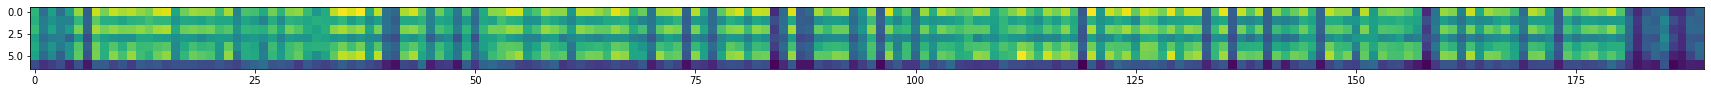

In [72]:
def relu(x: np.ndarray, relu_th: float = 0.0) -> np.ndarray:
  _relu = x * (x > relu_th)
  return _relu


X = doc_embeddings
distance_matrix = pairwise_distances(X, centroids, metric='cosine', n_jobs=1)
# distance_matrix = relu ( ((distance_matrix * -1)+1) , _mx-0.01)

distance_matrix = (distance_matrix * -1)+1.0
distance_matrix = distance_matrix.T
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))

threshold 0.8

--------------------
0=cluster 	 0.8997108936309814=similarity, 
 в) иные документы в форме надлежащим образом заверенных Заемщиком копий, подтверждающие целевое использование Кредитов, включая счета-фактуры и/или выписки (выдержки) из заключенных Заемщиком договоров, содержащие условия о предмете таких договоров, по письменному требованию Банка, в том числе, в случае, если целевое использование денежных средств, полученных Заемщиком в качестве Кредита, 
--------------------
--------------------
--------------------
--------------------
--------------------
5=cluster 	 0.8910732865333557=similarity, 
 (1) копии годового бухгалтерского баланса и отчета о финансовых результатах Заемщика, включая копии приложений к указанным документам с отметкой налоговой инспекции, либо с приложением копии квитанций об отправлении отчетности почтой с описью вложений или копии протокола входного контроля при отправке отчетности в электронном виде, подписанные руководителем и заверенные печ

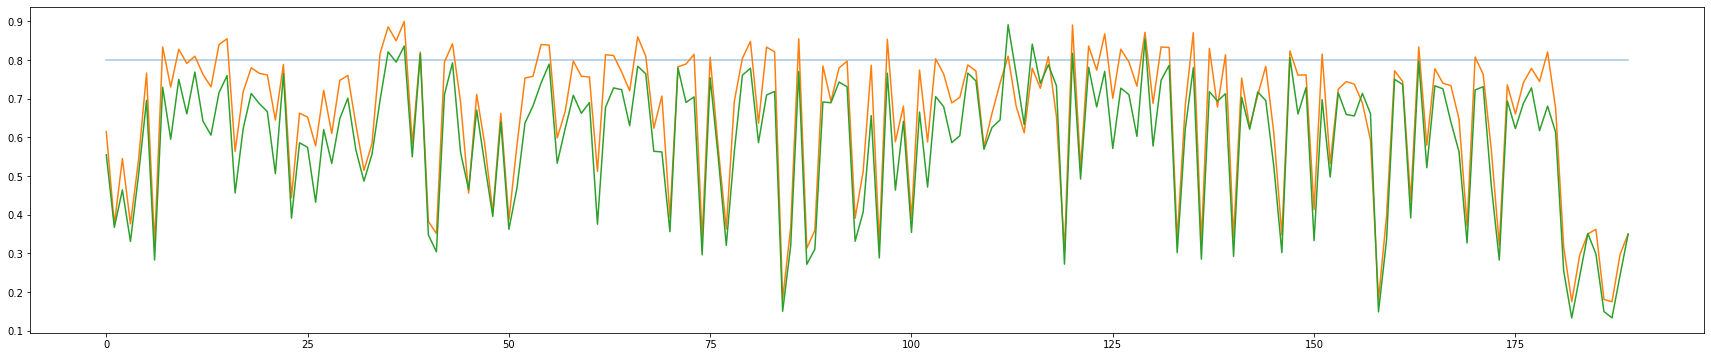

In [73]:
eps = 0.01
threshold = 0.8 #0.9 *  distance_matrix.max()
print('threshold', threshold)
print()
sim_max=0
i_max=0
plt.figure(figsize=(30,6))
plt.plot([threshold]*len(sample_doc.sentence_map), alpha=0.4 )
for k in range(len(kmeans.cluster_centers_)):    
    print('-'*20)
    v = distance_matrix[k] 
    av = v #relu(v, threshold) ## attention vector
    
    ii = av.argmax()
    sim = av[ii]
    if (sim > threshold):
        plt.plot(av)
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
    
    if sim>sim_max:
        i_max = k
        sim_max = sim
print(sim_max, i_max)

In [76]:
relu_threshold =  0.99 *  distance_matrix.max()
renderer_.render_color_text(sample_doc.sentence_map.tokens, relu(distance_matrix[i_max], relu_threshold), _range=(0,1))

## Test no-insides DOC

In [82]:
from bson import ObjectId
from analyser.legal_docs import tokenize_doc_into_sentences_map
# doc =

if SELF_TEST:
    sample_db_doc    =  get_doc_by_id(ObjectId('60dec1f556214d9842813fcb'))    
    sample_j_doc  = DbJsonDoc(sample_db_doc)
    sample_doc    = sample_j_doc.asLegalDoc()
    
    
    print(sample_doc)
    sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), mean_len)

#     print(sample_doc)

    doc_embeddings = embedder.embedd_strings(sample_doc.sentence_map.tokens)

65


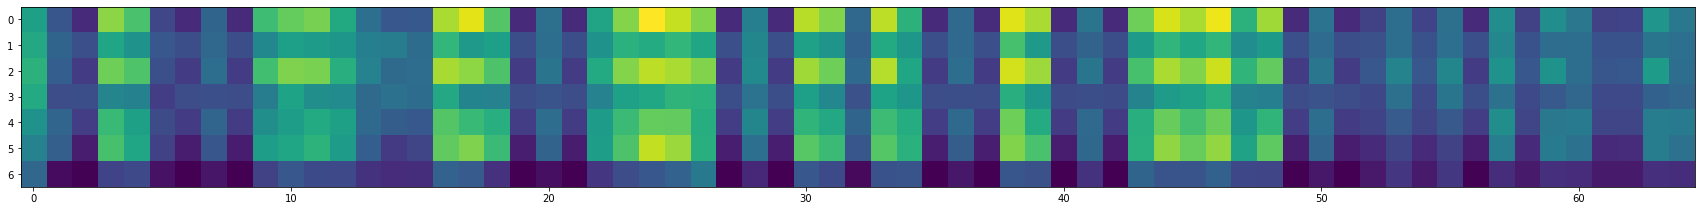

In [83]:
X = doc_embeddings
distance_matrix = pairwise_distances(X, centroids, metric='cosine', n_jobs=1)
# distance_matrix = relu ( ((distance_matrix * -1)+1) , _mx-0.01)

distance_matrix = (distance_matrix * -1)+1.0
distance_matrix = distance_matrix.T
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))

threshold 0.85

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
0.8406638 0


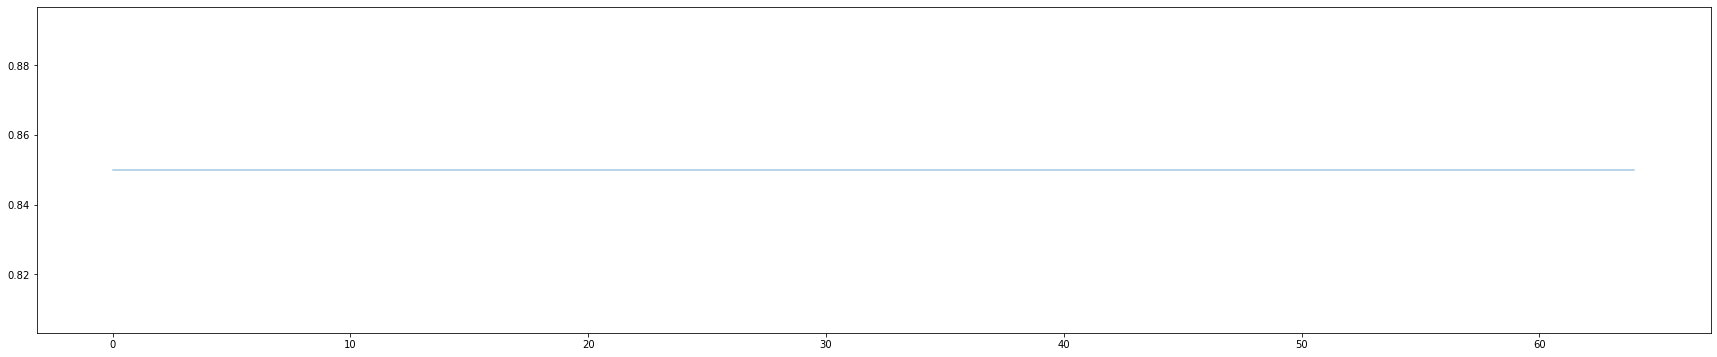

In [86]:
eps = 0.01
threshold = 0.85 #0.9 *  distance_matrix.max()
print('threshold', threshold)
print()
sim_max=0
i_max=0
plt.figure(figsize=(30,6))
plt.plot([threshold]*len(sample_doc.sentence_map), alpha=0.4 )
for k in range(len(kmeans.cluster_centers_)):    
    print('-'*20)
    v = distance_matrix[k] 
    av = v #relu(v, threshold) ## attention vector
    
    ii = av.argmax()
    sim = av[ii]
    if (sim > threshold):
        plt.plot(av)
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
    
    if sim>sim_max:
        i_max = k
        sim_max = sim
print(sim_max, i_max)

In [94]:
relu_threshold =  0.99 *  distance_matrix.max()
renderer_.render_color_text(sample_doc.sentence_map.tokens, distance_matrix[i_max])